# Dependencies

In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import pdfo
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("paper",font_scale=1.2)
import statsmodels.api as sm
LOWESS = sm.nonparametric.lowess
import eofs
import xrft
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import tqdm
import cmocean
import palettable
from shapely.geometry.polygon import LinearRing
import copy
import warnings

import pyarrow as pa
import pyarrow.parquet as pq

from IPython.display import display, clear_output

## get my stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

from fair import *

## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',list(get_palette.tab10().to_sn_palette()))
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

plt.rcParams['hatch.color']='k'
plt.rcParams['hatch.linewidth']=0.5

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=False,lon=False):
    if not lon is False:
        ax.set_xticks(lon, crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if not lat is False:
        ax.set_yticks(lat, crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

## Define functions

In [3]:
## function for hacking seaborn's catplot to make it pretty

def hack_catplot_range(x,y,hue,ci=66,dodge=False,hue_order=False,palette=False,**kwargs):
    
    x = x.astype(str)
    
    # calculate desired quantiles
    quantiles = [0.5-ci/200 , 0.5+ci/200]
    
    # calculate x data
    plot_x = dict(zip(x.unique(),np.arange(x.unique().size)))
    
    # if hue order
    if not hue_order:
        hue_order = hue.unique().tolist()
    
    hue_number = len(hue_order)
    
    # if dodge
    if dodge:
        plot_x_dodge = dict(zip(hue_order,np.linspace(-dodge/2,dodge/2,hue_number)))
    else:
        plot_x_dodge = dict(zip(hue.unique(),np.zeros(hue_number)))
    
    # groupby x,hue and plot
    for i,((x_level,hue_level),gr) in enumerate(y.groupby([x,hue])):
        
        if palette:
            kwargs['color'] = palette[hue_order.index(hue_level)]
        
        _y = np.nanquantile(gr.values,quantiles,interpolation='nearest')
        ## replace infs
        _y = np.where(np.isinf(_y),999999,_y)
        
        _x = plot_x[x_level] + plot_x_dodge[hue_level]
        
        plt.vlines(_x,*_y,lw=matplotlib.rcParams['lines.linewidth']*1.8,**kwargs)

In [4]:
palette = get_palette.IBM_color_blind().to_sn_palette()
palette1 = get_palette.color_blind().to_sn_palette()

# Retrieve data

Get Anthropogenic Warming Index.

In [5]:
## HadCRUT5
HC5 = xr.open_dataset('./ancil/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.nc')
HC5 = HC5.tas_mean.to_pandas()
HC5.index = HC5.index.year

## ERF components from AR6
erf_ar6 = pd.read_csv('./ancil/AR6_ERF_1750-2019.csv',index_col=0)

## ant / nat FaIR run
fair_erf = pd.DataFrame(index=erf_ar6.index,columns=pd.MultiIndex.from_product([['ant','aer','nat'],['forcing']]),data=pd.concat([erf_ar6.loc[:,'total_anthropogenic']-erf_ar6.loc[:,'aerosol'],erf_ar6.loc[:,'aerosol'],erf_ar6.loc[:,'total_natural']],axis=1).values)
fair_emms = return_empty_emissions(start_year=1750,end_year=2019,scen_names=['ant','aer','nat'])
fair_temps = run_FaIR(emissions_in=fair_emms,forcing_in=fair_erf)['T'].loc[1850:]

## regress HadCRUT5 onto FaIR temperature output & define anthropogenic warming index
X = np.column_stack([np.ones(fair_temps.index.size),fair_temps])
Y = HC5.loc[1850:2019].values[:,None]
mlr = OLSE.multiple(Y)
mlr.fit(X)
AWI = ( mlr.B[1]*fair_temps.aer + mlr.B[2]*fair_temps.ant ).default

Integrating 3 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|o3', 'cfc114', 'cfc114|o3', 'cfc115', 'cfc115|o3', 'cfc11|o3', 'cfc12', 'cfc12|o3', 'ch2cl2', 'ch2cl2|o3', 'ch3ccl3', 'ch3ccl3|o3', 'chcl3', 'chcl3|o3', 'co', 'co|o3', 'halon1202', 'halon1202|o3', 'halon1211', 'halon1211|o3', 'halon1301', 'halon1301|o3', 'halon2402', 'halon2402|o3', 'hcfc141b', 'hcfc141b|o3', 'hcfc142b', 'hcfc142b|o3', 'hcfc22', 'hcfc22|o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|o3', 'methyl_bromide', 'methyl_bromide|o3', 'methyl_chloride', 'methyl_chloride|o3', 'nf3', 'nh3', 'nitrous_oxide', 'nitrous_oxide|o3', 'nmvoc', 'nmvoc|o3', 'nox', 'nox_avi'

100%|██████████| 269/269 [00:00<00:00, 3356.43 timestep/s]


## REGIONS

Get E-Obs observations.

In [6]:
def preproc_eobs_rg(ds):
    
    ds = ds.copy()
    metric = ds.encoding['source'].split('/')[-1].split('_')[-2]
    RG = ds.encoding['source'].split('/')[-2]
    ds['time'] = ds.time.dt.year
    
    return ds.expand_dims({'metric':[metric],'region':[RG]}).transpose('time',...)

EObs_RG = xr.open_mfdataset('/home/leachl/Documents/Attribution/BAMs_2018_Europe_summer/Obsv_return/regions/*/E_Obs_0.25deg_TX*av_*.nc',preprocess=preproc_eobs_rg).sel(metric=['TX10av','TX1av','TX90av']).squeeze().rename(tg='t2m')

Get HadGEM3A simulations.

In [7]:
def preproc_hadgem_rg(ds):
    
    ds = ds.copy()
    metric = ds.encoding['source'].split('/')[-2]
    RG = ds.encoding['source'].split('/')[-3]
    ds = ds.assign_coords(record=np.arange(ds.record.size))
    ds['time'] = ds.time.dt.year
    ds['tas'] = ds.tas-273.15
    
    return ds.expand_dims({'metric':[metric],'region':[RG]}).transpose('time',...)

CLIM_paths = [glob.glob('/media/leachl/TOSHIBA EXT/Nicks_Documents/Attribution_data/soge-home/users/linc3691/HadGEM3A/clim/TMEAN/regions/*/'+x+'/MERGED.nc') for x in ['TX10av','TX1av','TX90av']]
CLIM_RG = xr.concat([xr.open_mfdataset(x,preprocess=preproc_hadgem_rg,concat_dim='region') for x in CLIM_paths],dim='metric').squeeze().rename(tas='t2m').load()

Get RACMO simulations.

In [8]:
def preproc_racmo_rg(ds):
    
    ds = ds.copy()
    metric = ds.encoding['source'].split('/')[-2]
    RG = ds.encoding['source'].split('/')[-3]
    ds = ds.assign_coords(record=np.arange(ds.record.size))
    ds['time'] = ds.time.dt.year
    ds['t2m'] = ds.t2m-273.15
    ds = ds.sel(time=slice(1950,2018))
    
    return ds.expand_dims({'metric':[metric],'region':[RG]}).transpose('time',...)

RACMO_paths = [glob.glob('/media/leachl/TOSHIBA EXT/Nicks_Documents/Attribution_data/RACMO/TMEAN/regions/*/'+x+'/MERGED.nc') for x in ['TX10av','TX1av','TX90av']]
RACMO_RG = xr.concat([xr.open_mfdataset(x,preprocess=preproc_racmo_rg,concat_dim='region') for x in RACMO_paths],dim='metric').squeeze().load()

Get EUROCORDEX simulations.

In [9]:
def preproc_ec_rg(ds):
    
    ds = ds.copy()
    metric = ds.encoding['source'].split('/')[-2]
    RG = ds.encoding['source'].split('/')[-3]
    ds = ds.assign_coords(record=np.arange(ds.record.size)).rename(tasAdjust='t2m')
    ds['time'] = ds.time.dt.year
    ds['t2m'] = ds.t2m-273.15
    ds = ds.sel(time=slice(1950,2018))
    
    return ds.expand_dims({'metric':[metric],'region':[RG]}).transpose('time',...)

EC_paths = [glob.glob('/media/leachl/TOSHIBA EXT/Nicks_Documents/Attribution_data/EUROCORDEX/TMEAN/regions/*/'+x+'/MERGED.nc') for x in ['TX10av','TX1av','TX90av']]
EC_RG = xr.concat([xr.open_mfdataset(x,preprocess=preproc_ec_rg,concat_dim='region') for x in EC_paths],dim='metric').squeeze().load()

# Analysis

## Observed return time

### bootstrap obervations

In [10]:
## set the number of bootstrap members
n_boot = 10000

def generate_boot(ds):
    
    ## bootstrap the samples
    x = ds.values
    np.random.seed(0)
    seed = np.random.choice(x.shape[0],x.shape[0]*n_boot)
    
    ## set the first seed equal to the original data for ease
    seed[::n_boot] = np.arange(x.shape[0])
    
    boot = x[seed].reshape(x.shape[0],seed.size//x.shape[0],*x.shape[1:])
    
    coords = dict(ds.coords)
    coords['seed'] = np.arange(n_boot)
    
    ds_out = xr.DataArray(boot, dims=[ds.dims[0],'seed',*ds.dims[1:]], coords=coords).rename(ds.name).to_dataset()
    
    ## need to record the years for detrending
    idx_boot = ds[ds.dims[0]].values[seed].reshape(x.shape[0],seed.size//x.shape[0])
    
    idx_coords = dict(ds[ds.dims[0]].coords)
    idx_coords['seed'] = np.arange(n_boot)
    
    ds_out['idx_'+ds.dims[0]] = xr.DataArray(idx_boot, dims=[ds.dims[0],'seed'], coords=idx_coords)
    
    return ds_out

In [11]:
## this definition required to get the year of the resamples in the ensembles
vector_sel = np.vectorize(lambda x: x[0])

EObs_RG_boot = generate_boot(EObs_RG.t2m.transpose('time',...))

CLIM_RG_boot = generate_boot(CLIM_RG.t2m.stack(idx=['time','record']).transpose('idx',...))
CLIM_RG_boot['idx_time'] = (['idx','seed'],vector_sel(CLIM_RG_boot.idx_idx.values))

RACMO_RG_boot = generate_boot(RACMO_RG.t2m.stack(idx=['time','record']).transpose('idx',...))
RACMO_RG_boot['idx_time'] = (['idx','seed'],vector_sel(RACMO_RG_boot.idx_idx.values))

EC_RG_boot = generate_boot(EC_RG.t2m.stack(idx=['time','record']).transpose('idx',...))
EC_RG_boot['idx_time'] = (['idx','seed'],vector_sel(EC_RG_boot.idx_idx.values))

### detrend

In [12]:
def detrend(ds):
    
    """
    This function regresses (OLS) timeseries onto the Anthropogenic Warming Index.
    """
    
    ## detrend observations using AWI
    slr = OLSE.simple(ds.t2m.values)
    slr.fit(AWI.loc[ds.idx_time.values.flatten()].values.reshape(ds.idx_time.shape)[...,None,None])
    
    ### remove attributable trend, shifting to a pseudo-stationary 2018 climatology
    ds['t2m_trend'] = (['seed','metric','region'],slr.b1)
    ds['t2m_dt'] = ds.t2m - (slr.pred() - slr.pred(AWI.loc[2018]))

In [13]:
detrend(EObs_RG_boot)
detrend(CLIM_RG_boot)
detrend(RACMO_RG_boot)
detrend(EC_RG_boot)

In [14]:
t2m_trend_df = pd.concat([x.t2m_trend.to_dataframe().t2m_trend.reset_index() for x in [EObs_RG_boot,CLIM_RG_boot,RACMO_RG_boot,EC_RG_boot]],keys=['E-Obs','HadGEM3-A','RACMO','EURO-CORDEX'],names=['source']).reset_index(level=0).reset_index(drop=True).dropna()

''

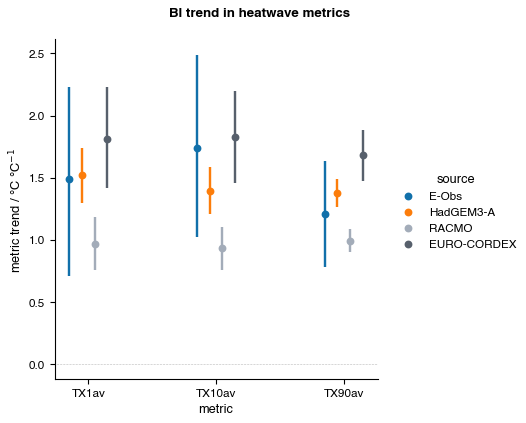

In [15]:
choose_region = 'BI'

g=sn.catplot(data=t2m_trend_df.query('region=="'+choose_region+'"').sort_values(by='metric',key=lambda x: x.map(dict(TX1av=0,TX10av=1,TX90av=2))),y='t2m_trend',x='metric',hue='source',hue_order=['E-Obs','HadGEM3-A','RACMO','EURO-CORDEX'],kind='point',ci=None,estimator=np.nanmedian,join=False,dodge=0.3,palette=palette1[:4],scale=1,aspect=1)    
    
g.map(hack_catplot_range,'metric','t2m_trend','source',ci=90,hue_order=['E-Obs','HadGEM3-A','RACMO','EURO-CORDEX'],dodge=0.3,palette=palette1[:4])

g.set(ylabel='metric trend / \N{DEGREE SIGN}C \N{DEGREE SIGN}C$^{-1}$',xlabel='metric')
g.axes[0,0].axhline(0,ls=':',color='grey',lw=0.5)
g.fig.dpi=80
g.fig.patch.set_facecolor('xkcd:white')
g.fig.suptitle(choose_region+' trend in heatwave metrics',fontweight='bold',y=1.05)
''

### EVT

Find climatological return period based on detrended E-Obs.

In [16]:
## fit GEV distributions to the detrended data
gev = LMoments.gev()
gev.fit(EObs_RG_boot.t2m_dt.values)

RP = 1/(1-gev.cdf(EObs_RG.t2m.sel(time=2018).values))

EObs_RG_boot['RP'] = (['seed','metric','region'], RP)

## repeat with GLO for TX90av
glo = LMoments.glo()
glo.fit(EObs_RG_boot.t2m_dt.sel(metric='TX90av').values)

EObs_RG_boot['RP'][:,-1] = 1/(1-glo.cdf(EObs_RG.t2m.sel(metric='TX90av',time=2018).values))

/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:244: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


''

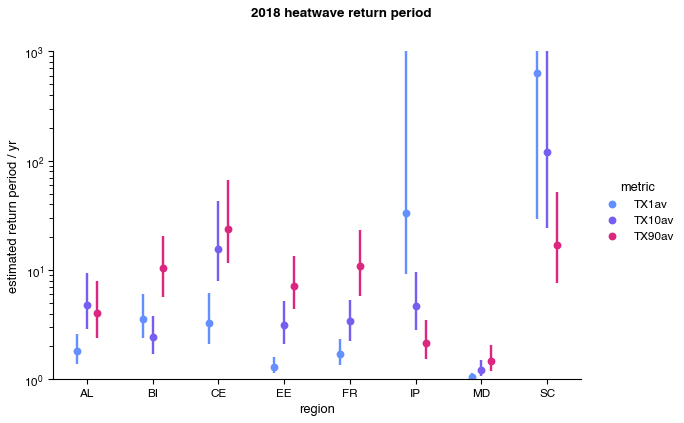

In [17]:
g=sn.catplot(data=EObs_RG_boot.RP.to_dataframe().RP.reset_index(),y='RP',x='region',hue='metric',hue_order=['TX1av','TX10av','TX90av'],kind='point',ci=None,estimator=np.nanmedian,join=False,dodge=0.3,palette=palette[:3],scale=1,aspect=1.5)    
    
g.map(hack_catplot_range,'region','RP','metric',ci=90,hue_order=['TX1av','TX10av','TX90av'],dodge=0.3,palette=palette[:3])

g.set(ylabel='estimated return period / yr',xlabel='region',yscale='log',ylim=(1,1e3))
g.axes[0,0].axhline(0,ls=':',color='grey',lw=0.5)
g.fig.dpi=80
g.fig.patch.set_facecolor('xkcd:white')
g.fig.suptitle('2018 heatwave return period',fontweight='bold',y=1.05)
''

Find climatological threshold & risk ratio in ensembles.

In [18]:
def ensemble_EVT(ds):
    
    """
    This function fits GEV distributions to (detrended) data 
    & computes:
    1. 2018 t2m thresholds based on the E-Obs 2018 quantile
    2. Risk ratios based on shifting the GEV per metric trends
    """

    EObs_RP = EObs_RG_boot.RP.sel(region=ds.region.values)
    
    ## fit GEV distributions to the detrended data
    gev = LMoments.gev()
    gev.fit(ds.t2m_dt.values)

    ## compute threshold based on E-Obs return period
    threshold = gev.qf(1-1/EObs_RP.values)
    ds['t2m_threshold'] = (['seed','metric','region'], threshold)
    
    ## now re-compute return period of this threshold with shifted distribution
    gev_shift = copy.deepcopy(gev)
    gev_shift.X = gev_shift.X - (ds.t2m_trend * (AWI.loc[2018].mean() - AWI.loc[1850:1900].mean())).values
    
    ## use the threshold + shifted distribution to compute risk ratio
    RR = (1/(1-gev_shift.cdf(threshold))) / EObs_RP.values
    ds['risk_ratio'] = (['seed','metric','region'], RR)

    ## repeat with GLO for TX90av
    glo = LMoments.glo()
    glo.fit(ds.t2m_dt.sel(metric='TX90av').values)

    ds['t2m_threshold'][:,-1] = glo.qf(1-1/EObs_RP.sel(metric='TX90av').values)
    
    glo_shift = copy.deepcopy(glo)
    glo_shift.X = glo_shift.X - (ds.t2m_trend.sel(metric='TX90av') * (AWI.loc[2018].mean() - AWI.loc[1850:1900].mean())).values
    
    RR = (1/(1-glo_shift.cdf(ds.t2m_threshold.sel(metric='TX90av').values))) / EObs_RP.sel(metric='TX90av').values
    ds['risk_ratio'][:,-1] = RR

In [19]:
ensemble_EVT(EObs_RG_boot)
ensemble_EVT(CLIM_RG_boot)
ensemble_EVT(RACMO_RG_boot)
ensemble_EVT(EC_RG_boot)

/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:244: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:425: RuntimeWarning: invalid value encountered in power
  cdf = 1/( 1 + (1-self.k*(x-self.X)/self.a)**(1/self.k) )
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


In [20]:
RR_df = pd.concat([x.risk_ratio.to_dataframe().risk_ratio.reset_index() for x in [EObs_RG_boot,CLIM_RG_boot,RACMO_RG_boot,EC_RG_boot]],keys=['E-Obs','HadGEM3-A','RACMO','EURO-CORDEX'],names=['source']).reset_index(level=0).reset_index(drop=True).dropna()

''

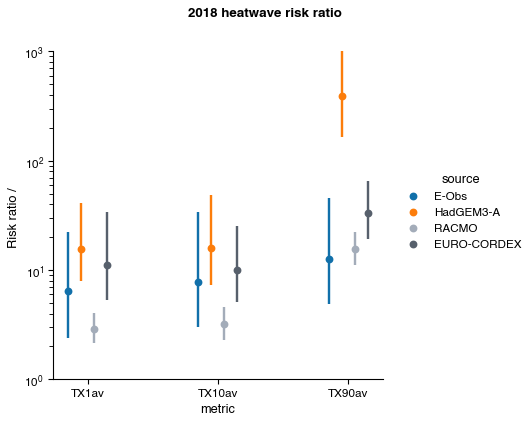

In [21]:
choose_region = 'BI'

g=sn.catplot(data=RR_df.query('region=="'+choose_region+'"').sort_values(by='metric',key=lambda x: x.map(dict(TX1av=0,TX10av=1,TX90av=2))),y='risk_ratio',x='metric',hue='source',hue_order=['E-Obs','HadGEM3-A','RACMO','EURO-CORDEX'],kind='point',ci=None,estimator=np.nanmedian,join=False,dodge=0.3,palette=palette1[:4],scale=1,aspect=1)    
    
g.map(hack_catplot_range,'metric','risk_ratio','source',ci=90,hue_order=['E-Obs','HadGEM3-A','RACMO','EURO-CORDEX'],dodge=0.3,palette=palette1[:4])

g.set(ylabel='Risk ratio / ',xlabel='metric',yscale='log',ylim=(1,1e3))
g.axes[0,0].axhline(0,ls=':',color='grey',lw=0.5)
g.fig.dpi=80
g.fig.patch.set_facecolor('xkcd:white')
g.fig.suptitle('2018 heatwave risk ratio',fontweight='bold',y=1.05)
''